<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a><div align="center">This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.</div>

----

# Preparing the environment

## Graphics and plotting

The following block of code initializes the Python plotting library [matplotlib](http://matplotlib.org/gallery.html) and configures it to show figures embedded in the notebook (as opposed to opening a new window for each figure):

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

The Seaborn library provides easy-to-use plotting functions for common plot types, and better default visual styles.

In [2]:
import seaborn as sea

Set the default size and style of the plot.  (Plots are styled to [look like R's `ggplot`](http://tonysyu.github.io/mpltools/auto_examples/style/plot_ggplot.html) library.)

In [3]:
matplotlib.rcParams['figure.figsize'] = (10, 7)

sea.set_style('dark')

## SQL database connection

The ESC403 cluster comes preinstalled with [Catherine Devlin's `%sql`-magic for IPython][1]; this allows you to run SQL queries from the IPython notebook, and intermix them with Python code.

[1]: https://github.com/catherinedevlin/ipython-sql

Before we can use the `%sql` syntax, two steps must be taken:

* Load the IPython-SQL bridge code

In [4]:
%load_ext sql

* Connect to an actual database; this must be the first `%sql` statement (the `rmurri@/lustre` syntax means "connect to the PostGreSQL DB named `lustre` running on *this* host as user `rmurri`" -- of course change `rmurri` to *your* user name):

In [5]:
%sql postgresql://rmurri@/lustre


u'Connected: rmurri@lustre'

Now you can run 1-line SQL queries by prefixing them with `%sql` or multi-line ones with `%%sql`

# Exploring the dataset

In [6]:
%sql select * from lustre limit 5;

5 rows affected.


usr,grp,atime,mtime,blksize,size,path
usr388,i5105,1384452271,1384452271,4,2203,/scratch/bioc/usr388/VS_AllNow_libo_3WAT/ledock_pose/LIBO00170060_dock014.pdb
usr388,i5105,1384452311,1384452311,4,1708,/scratch/bioc/usr388/VS_AllNow_libo_3WAT/ledock_pose/LIBO00171011_dock014.pdb
usr388,i5105,1384452490,1384452490,4,1213,/scratch/bioc/usr388/VS_AllNow_libo_3WAT/ledock_pose/LIBO00174084_dock006.pdb
usr388,i5105,1384452674,1384452674,4,1488,/scratch/bioc/usr388/VS_AllNow_libo_3WAT/ledock_pose/LIBO00179374_dock004.pdb
usr388,i5105,1384453267,1384453267,4,1708,/scratch/bioc/usr388/VS_AllNow_libo_3WAT/ledock_pose/LIBO00205410_dock007.pdb


The `%sql` "magic" can also be used as an expression: it returns the result table as a Python `list` of tuples:

In [7]:
%%time

result = %sql SELECT size, count(path) FROM lustre_sample GROUP BY size ORDER BY size ASC LIMIT 100;

100 rows affected.
CPU times: user 0 ns, sys: 6.88 ms, total: 6.88 ms
Wall time: 2.06 s


Now the `result` list can be used in code as if we had defined it in Python directly:

In [8]:
result[:5]

[(0L, 12722L), (1L, 15L), (2L, 20L), (3L, 2L), (4L, 43L)]

## Plotting results

In order to plot results, we need to have separate lists/arrays for the X-axis values and the corresponding Y-axis values.


Python's `zip` function is used to split the result table into independent lists (all first elements, all second elements):

In [9]:
sizes, occurrences = zip(*result)

In [10]:
sizes[:5], occurrences[:5]

((0L, 1L, 2L, 3L, 4L), (12722L, 15L, 20L, 2L, 43L))

The `plt.plot()` function is used to make a line plot; here we show how to place "sizes" on the X-axis and "occurrences" on the Y-axis:

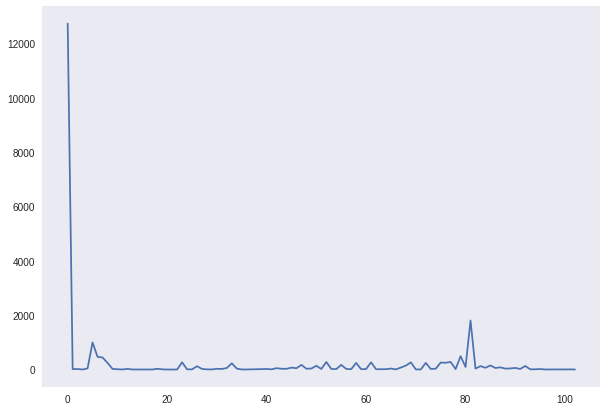

In [11]:
plt.plot(sizes, occurrences)

---

## 1. Plot distribution by block size

Plot the number of files of a certain *block size* (column `blksize`).  The *block size* is the actual size allocated on the disk, measured in blocks (size depends on the filesystem -- here 1 block is 1MB).

In [12]:
result = %sql SELECT blksize, COUNT(path) FROM lustre_sample GROUP BY blksize ORDER BY blksize

23028 rows affected.


**Note:** The `ORDER BY` clause is necessary to get data in a format that makes sense in the plots below (the plotting functions do not make any manipulation on the data).

We can apply the same technique as before to split `result` into separate lists `x` and `y` that we are going to feed the plotting function.

In [13]:
x, y = zip(* result)

In [14]:
x[:5], y[:5]

((0, 4, 8, 12, 16), (12722L, 819230L, 118067L, 31321L, 10824L))

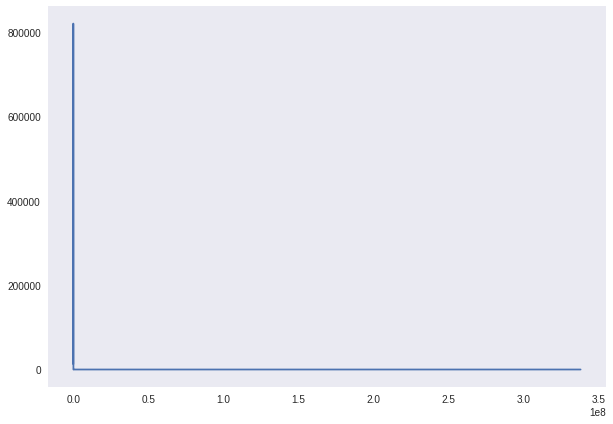

In [15]:
plt.plot(x, y)

A spike of outliers makes the plot non-informative.  Let's split in two and plot separately (so we get a different bounding box).

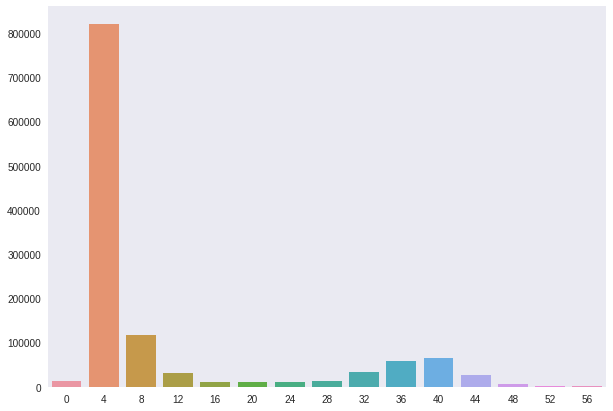

In [16]:
x1, y1 = x[:15], y[:15]

sea.barplot(x1, y1)

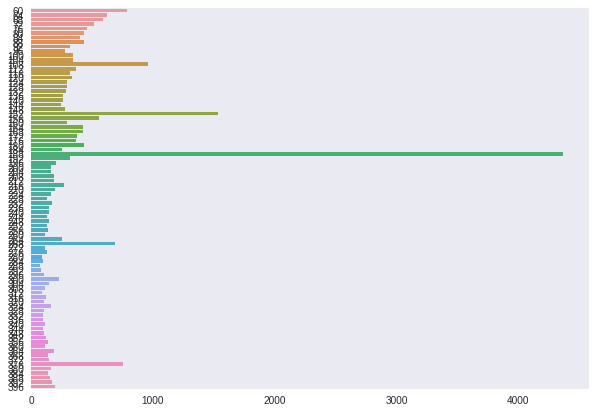

In [17]:
x2, y2 = x[15:100], y[15:100]

sea.barplot(y2, x2, orient="h")

**Note:** `x` and `y` are swapped in the call to `barplot()` with horizontal orientation!

## 2. Plot number of users by number of (owned) files

For each user *u*, let *N(u)* be the number of files owned by user *u*.  For each integer *K*, compute and plot the number of users *u* such that *N(u) = K*.

In [19]:
result = %sql SELECT usr, COUNT(path) AS cnt FROM lustre_sample GROUP BY usr ORDER BY cnt ASC

40 rows affected.


In [20]:
result[:5]

[(u'usr390', 1L),
 (u'usr75', 3L),
 (u'us345', 4L),
 (u'usr261', 7L),
 (u'usr352', 9L)]

This SQL query has computed the mapping ${usr} \to {blksize}$ but we need to compute the *distribution* of values from this map to answer the question.  We can of course use Python code to do this (there are even [survey articles listing all the ways to do it](http://treyhunner.com/2015/11/counting-things-in-python/)) but, since computing a distribution of integer values can be done by grouping and counting, we can have the SQL server do it for us.

In [21]:
result = %sql SELECT sub.cnt, COUNT(sub.usr) FROM (SELECT usr, COUNT(path) AS cnt FROM lustre_sample GROUP BY usr) AS sub GROUP BY sub.cnt ORDER BY sub.cnt ASC

40 rows affected.


In [22]:
result[:5]

[(1L, 1L), (3L, 1L), (4L, 1L), (7L, 1L), (9L, 1L)]

In [23]:
counts, n_users = zip(* result)

In [24]:
counts[:5], n_users[:5]

((1L, 3L, 4L, 7L, 9L), (1L, 1L, 1L, 1L, 1L))

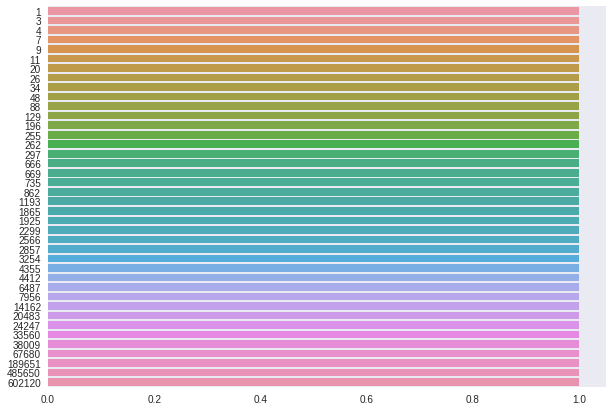

In [25]:
sea.barplot(n_users, counts, orient="h")

The plot is not particularly telling!  Apparently, there's a 1-1 correspondence between users and number of files.

To get better insights, we might want to plot a histogram of the *counts* variable.  This is done (logically, and also practically with Python) in two steps:

1. *bin* the input data into a series of consecutive non-overlapping intervals; this is done with the [`numpy.histogram`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html) function
2. plot the count of items falling into each bin as a bar plot

The [NumPy](http://www.numpy.org/) package is needed for the following, so import it using the customary abbreviation `np`:

In [26]:
import numpy as np

The [`numpy.histogram()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html) takes a series of values and returns two arrays defining a histogram:

- first return value `hist` is an array counting the number of items falling into each bin
- second return value `bin_edges` is an array of the *separating values* between consecutive bins (i.e., the first bin extends from `bin_edges[0]` to `bin_edges[1]` etc.)

Note that array `bin_edges` is 1 item longer than array `hist`.

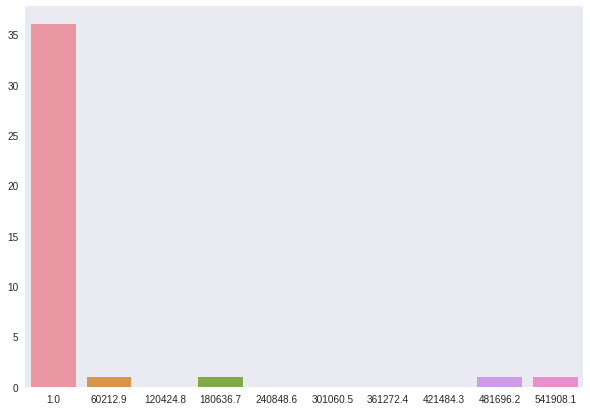

In [27]:
hist, bin_edges = np.histogram(np.array(counts))

sea.barplot(bin_edges[:-1], hist)

Separating binning from plotting makes it simple to operate on log-scale; note how the NumPy functions can operate on whole arrays:

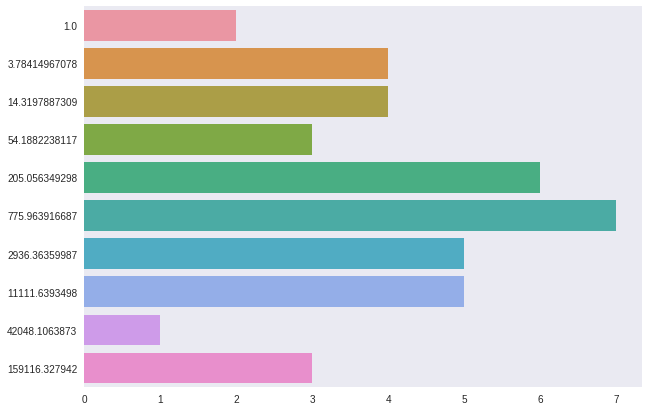

In [28]:
log_counts = np.log10(counts)

hist, bin_edges = np.histogram(log_counts)

sea.barplot(hist, np.power(10, bin_edges[:-1]), orient="h")

Actually, the SeaBorn library already provides a [`seaborn.distplot()`](http://seaborn.pydata.org/generated/seaborn.distplot.html) function to perform all of it in one go (and with better/meaningful axis labels).

Note that the values must be passed to `seaborn.distplot` as a [NumPy array](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html).

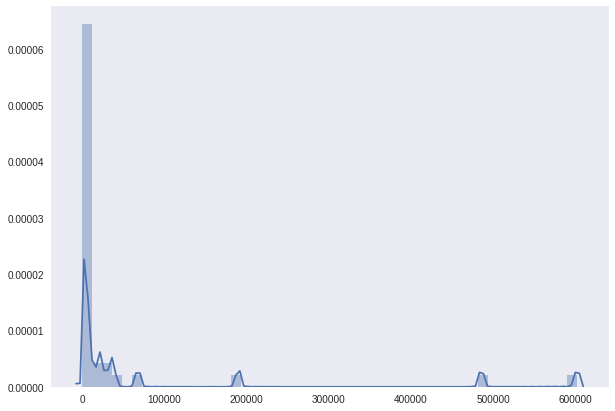

In [29]:
sea.distplot(np.array(counts))

Additional parameters may be given to `seaborn.distplot` to avoid plotting the Gaussian kernel estimate -- in this case, there is no need to convert input data to a NumPy array:

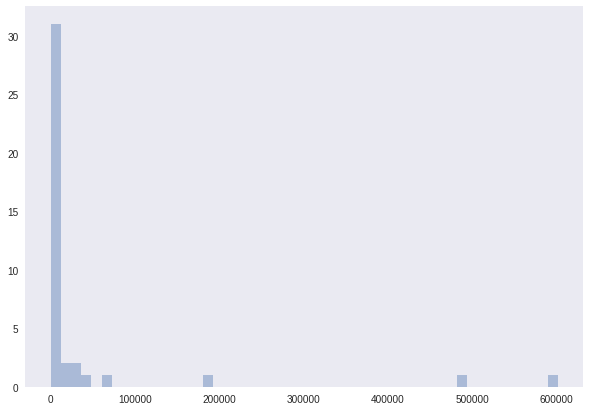

In [30]:
sea.distplot(counts, kde=False, norm_hist=False)